In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset
from torch.utils.data import ConcatDataset
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")


In [2]:
root = dir_path = os.path.join(os.getcwd(), 'LCC_FASD')
train_path_real = os.path.join(root, 'LCC_FASD_training', 'real')
train_path_spoof = os.path.join(root, 'LCC_FASD_training', 'spoof')
dev_path_real = os.path.join(root, 'LCC_FASD_development', 'real')
dev_path_spoof = os.path.join(root, 'LCC_FASD_development', 'spoof')
test_path = os.path.join(root, 'LCC_FASD_evaluation')
print(train_path_real)

/home/amanpro30/Desktop/BTP/LCC_FASD/LCC_FASD_training/real


In [3]:
# Resizing all images to (224,224)
transform = transforms.Compose([
    transforms.Resize(224), 
    transforms.ToTensor(),
    transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225])
])

In [4]:
class MyDataset(Dataset):
    def __init__(self, image_name_list, image_path, labels, transforms):
        self.image_path = image_path
        self.labels = labels
        self.transforms = transforms
        self.image_name_list = image_name_list

    def __getitem__(self, index):
        image = Image.open(os.path.join(self.image_path, self.image_name_list[index]))
        # Transform it to Tensor
        image = self.transforms(image)
        data = (image,self.labels[index])
        
        return data

    def __len__(self):
        return len(self.image_name_list)

In [5]:
for folder, subfolders, filenames in os.walk(train_path_real):
    break
labels = [int(1) for img in filenames]
real_images = MyDataset(filenames, train_path_real, labels, transform)

for folder, subfolders, filenames in os.walk(train_path_spoof):
    break
labels = [int(0) for img in filenames]
spoof_images = MyDataset(filenames, train_path_spoof, labels, transform)

for folder, subfolders, filenames in os.walk(test_path):
    break
labels = [int(0) if img.startswith('s') is True else int(1) for img in filenames]
test_images = MyDataset(filenames, test_path, labels, transform)

In [6]:
train_dataset = ConcatDataset([real_images, spoof_images])
test_dataset = test_images
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)

In [7]:
resNet50model = models.resnext50_32x4d(pretrained=True)
AlexNetmodel = models.alexnet(pretrained=True)

In [8]:
resNet50model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [10]:
for param in resNet50model.parameters():
    param.requires_grad = False

In [11]:
resNet50model.fc = nn.Sequential(nn.Linear(2048, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.4),
                                 nn.Linear(256, 2),
                                 nn.LogSoftmax(dim=1))
resNet50model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [12]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')

In [13]:
count_parameters(resNet50model)

  524288
     256
     512
       2
________
  525058


In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resNet50model.fc.parameters(), lr=0.001)

In [15]:
import time
start_time = time.time()

epochs = 30

max_trn_batch = 800
max_tst_batch = 300

train_losses = []
test_losses = []
train_correct = []
test_correct = []
train_accuracy = []
test_accuracy = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        if b == max_trn_batch:
            break
        b+=1
        
        # Apply the model
        y_pred = resNet50model(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%5 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/8000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)
    train_accuracy.append(trn_corr.item()*100/(10*b))

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            if b == max_tst_batch:
                break

            # Apply the model
            y_val = resNet50model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
    test_accuracy.append(test_correct[-1].item()*100/3000)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch:    5 [    50/8000]  loss: 0.56802797  accuracy:  82.000%
epoch:  0  batch:   10 [   100/8000]  loss: 0.70618218  accuracy:  73.000%
epoch:  0  batch:   15 [   150/8000]  loss: 0.44643322  accuracy:  76.667%
epoch:  0  batch:   20 [   200/8000]  loss: 0.84451520  accuracy:  78.500%
epoch:  0  batch:   25 [   250/8000]  loss: 0.14917888  accuracy:  80.400%
epoch:  0  batch:   30 [   300/8000]  loss: 0.35193720  accuracy:  80.000%
epoch:  0  batch:   35 [   350/8000]  loss: 0.34084156  accuracy:  81.143%
epoch:  0  batch:   40 [   400/8000]  loss: 0.55942333  accuracy:  80.500%
epoch:  0  batch:   45 [   450/8000]  loss: 0.50282103  accuracy:  81.556%
epoch:  0  batch:   50 [   500/8000]  loss: 0.48328024  accuracy:  82.000%
epoch:  0  batch:   55 [   550/8000]  loss: 0.11053864  accuracy:  83.091%
epoch:  0  batch:   60 [   600/8000]  loss: 0.10391350  accuracy:  83.000%
epoch:  0  batch:   65 [   650/8000]  loss: 0.15333894  accuracy:  83.385%
epoch:  0  batch:   70 [ 

epoch:  0  batch:  555 [  5550/8000]  loss: 0.42818770  accuracy:  87.135%
epoch:  0  batch:  560 [  5600/8000]  loss: 0.31624490  accuracy:  87.107%
epoch:  0  batch:  565 [  5650/8000]  loss: 0.08789791  accuracy:  87.186%
epoch:  0  batch:  570 [  5700/8000]  loss: 0.49172115  accuracy:  87.158%
epoch:  0  batch:  575 [  5750/8000]  loss: 0.61750710  accuracy:  87.148%
epoch:  0  batch:  580 [  5800/8000]  loss: 0.33189526  accuracy:  87.138%
epoch:  0  batch:  585 [  5850/8000]  loss: 0.41609937  accuracy:  87.145%
epoch:  0  batch:  590 [  5900/8000]  loss: 0.19359699  accuracy:  87.153%
epoch:  0  batch:  595 [  5950/8000]  loss: 0.14660478  accuracy:  87.210%
epoch:  0  batch:  600 [  6000/8000]  loss: 0.60691082  accuracy:  87.117%
epoch:  0  batch:  605 [  6050/8000]  loss: 0.12557563  accuracy:  87.157%
epoch:  0  batch:  610 [  6100/8000]  loss: 0.16832520  accuracy:  87.197%
epoch:  0  batch:  615 [  6150/8000]  loss: 0.26315135  accuracy:  87.236%
epoch:  0  batch:  620 [ 

epoch:  1  batch:  305 [  3050/8000]  loss: 0.45255241  accuracy:  90.754%
epoch:  1  batch:  310 [  3100/8000]  loss: 0.09074047  accuracy:  90.839%
epoch:  1  batch:  315 [  3150/8000]  loss: 0.27192926  accuracy:  90.825%
epoch:  1  batch:  320 [  3200/8000]  loss: 0.08341525  accuracy:  90.781%
epoch:  1  batch:  325 [  3250/8000]  loss: 0.23744658  accuracy:  90.769%
epoch:  1  batch:  330 [  3300/8000]  loss: 0.34675780  accuracy:  90.758%
epoch:  1  batch:  335 [  3350/8000]  loss: 0.21759498  accuracy:  90.746%
epoch:  1  batch:  340 [  3400/8000]  loss: 0.29681328  accuracy:  90.676%
epoch:  1  batch:  345 [  3450/8000]  loss: 0.10949675  accuracy:  90.667%
epoch:  1  batch:  350 [  3500/8000]  loss: 0.16032174  accuracy:  90.600%
epoch:  1  batch:  355 [  3550/8000]  loss: 0.17038274  accuracy:  90.732%
epoch:  1  batch:  360 [  3600/8000]  loss: 0.65721065  accuracy:  90.694%
epoch:  1  batch:  365 [  3650/8000]  loss: 0.25085524  accuracy:  90.685%
epoch:  1  batch:  370 [ 

epoch:  2  batch:   55 [   550/8000]  loss: 0.06610312  accuracy:  91.636%
epoch:  2  batch:   60 [   600/8000]  loss: 0.15371093  accuracy:  91.833%
epoch:  2  batch:   65 [   650/8000]  loss: 0.38494200  accuracy:  91.231%
epoch:  2  batch:   70 [   700/8000]  loss: 0.32931530  accuracy:  91.143%
epoch:  2  batch:   75 [   750/8000]  loss: 0.11642692  accuracy:  91.067%
epoch:  2  batch:   80 [   800/8000]  loss: 0.54683048  accuracy:  91.000%
epoch:  2  batch:   85 [   850/8000]  loss: 0.07717112  accuracy:  91.059%
epoch:  2  batch:   90 [   900/8000]  loss: 0.09738083  accuracy:  91.222%
epoch:  2  batch:   95 [   950/8000]  loss: 0.12565529  accuracy:  91.579%
epoch:  2  batch:  100 [  1000/8000]  loss: 0.89754522  accuracy:  91.200%
epoch:  2  batch:  105 [  1050/8000]  loss: 0.14932171  accuracy:  91.048%
epoch:  2  batch:  110 [  1100/8000]  loss: 0.28450197  accuracy:  91.000%
epoch:  2  batch:  115 [  1150/8000]  loss: 0.08365684  accuracy:  91.130%
epoch:  2  batch:  120 [ 

epoch:  2  batch:  605 [  6050/8000]  loss: 0.26914570  accuracy:  91.388%
epoch:  2  batch:  610 [  6100/8000]  loss: 0.13766882  accuracy:  91.393%
epoch:  2  batch:  615 [  6150/8000]  loss: 0.08202607  accuracy:  91.415%
epoch:  2  batch:  620 [  6200/8000]  loss: 0.13516021  accuracy:  91.403%
epoch:  2  batch:  625 [  6250/8000]  loss: 0.31140667  accuracy:  91.424%
epoch:  2  batch:  630 [  6300/8000]  loss: 0.14429556  accuracy:  91.476%
epoch:  2  batch:  635 [  6350/8000]  loss: 0.46576524  accuracy:  91.417%
epoch:  2  batch:  640 [  6400/8000]  loss: 0.35708782  accuracy:  91.422%
epoch:  2  batch:  645 [  6450/8000]  loss: 0.28562987  accuracy:  91.457%
epoch:  2  batch:  650 [  6500/8000]  loss: 0.13915832  accuracy:  91.446%
epoch:  2  batch:  655 [  6550/8000]  loss: 0.75218225  accuracy:  91.405%
epoch:  2  batch:  660 [  6600/8000]  loss: 0.12057710  accuracy:  91.439%
epoch:  2  batch:  665 [  6650/8000]  loss: 0.50997990  accuracy:  91.459%
epoch:  2  batch:  670 [ 

epoch:  3  batch:  355 [  3550/8000]  loss: 0.46252999  accuracy:  92.225%
epoch:  3  batch:  360 [  3600/8000]  loss: 0.07606556  accuracy:  92.333%
epoch:  3  batch:  365 [  3650/8000]  loss: 0.01681163  accuracy:  92.329%
epoch:  3  batch:  370 [  3700/8000]  loss: 0.47162515  accuracy:  92.297%
epoch:  3  batch:  375 [  3750/8000]  loss: 0.39608139  accuracy:  92.347%
epoch:  3  batch:  380 [  3800/8000]  loss: 0.10066453  accuracy:  92.368%
epoch:  3  batch:  385 [  3850/8000]  loss: 0.11392602  accuracy:  92.286%
epoch:  3  batch:  390 [  3900/8000]  loss: 0.26831275  accuracy:  92.231%
epoch:  3  batch:  395 [  3950/8000]  loss: 0.31932300  accuracy:  92.203%
epoch:  3  batch:  400 [  4000/8000]  loss: 0.10664779  accuracy:  92.225%
epoch:  3  batch:  405 [  4050/8000]  loss: 0.24979882  accuracy:  92.272%
epoch:  3  batch:  410 [  4100/8000]  loss: 0.18040498  accuracy:  92.220%
epoch:  3  batch:  415 [  4150/8000]  loss: 0.14243567  accuracy:  92.217%
epoch:  3  batch:  420 [ 

epoch:  4  batch:  105 [  1050/8000]  loss: 0.13397752  accuracy:  90.190%
epoch:  4  batch:  110 [  1100/8000]  loss: 0.12187135  accuracy:  90.364%
epoch:  4  batch:  115 [  1150/8000]  loss: 0.29138708  accuracy:  90.261%
epoch:  4  batch:  120 [  1200/8000]  loss: 0.11576021  accuracy:  90.333%
epoch:  4  batch:  125 [  1250/8000]  loss: 0.32195473  accuracy:  90.400%
epoch:  4  batch:  130 [  1300/8000]  loss: 0.02131113  accuracy:  90.615%
epoch:  4  batch:  135 [  1350/8000]  loss: 0.24699755  accuracy:  90.667%
epoch:  4  batch:  140 [  1400/8000]  loss: 0.04380471  accuracy:  90.714%
epoch:  4  batch:  145 [  1450/8000]  loss: 0.31684291  accuracy:  90.414%
epoch:  4  batch:  150 [  1500/8000]  loss: 0.18927158  accuracy:  90.333%
epoch:  4  batch:  155 [  1550/8000]  loss: 0.20426731  accuracy:  90.452%
epoch:  4  batch:  160 [  1600/8000]  loss: 0.31803578  accuracy:  90.500%
epoch:  4  batch:  165 [  1650/8000]  loss: 0.08448529  accuracy:  90.545%
epoch:  4  batch:  170 [ 

epoch:  4  batch:  655 [  6550/8000]  loss: 0.04017694  accuracy:  91.740%
epoch:  4  batch:  660 [  6600/8000]  loss: 0.10856505  accuracy:  91.773%
epoch:  4  batch:  665 [  6650/8000]  loss: 0.03480608  accuracy:  91.820%
epoch:  4  batch:  670 [  6700/8000]  loss: 0.25965622  accuracy:  91.806%
epoch:  4  batch:  675 [  6750/8000]  loss: 0.15717667  accuracy:  91.852%
epoch:  4  batch:  680 [  6800/8000]  loss: 0.10509076  accuracy:  91.897%
epoch:  4  batch:  685 [  6850/8000]  loss: 0.40848455  accuracy:  91.898%
epoch:  4  batch:  690 [  6900/8000]  loss: 0.09582857  accuracy:  91.913%
epoch:  4  batch:  695 [  6950/8000]  loss: 0.11967884  accuracy:  91.842%
epoch:  4  batch:  700 [  7000/8000]  loss: 0.20916526  accuracy:  91.857%
epoch:  4  batch:  705 [  7050/8000]  loss: 0.33671418  accuracy:  91.816%
epoch:  4  batch:  710 [  7100/8000]  loss: 0.06174503  accuracy:  91.817%
epoch:  4  batch:  715 [  7150/8000]  loss: 0.32040310  accuracy:  91.804%
epoch:  4  batch:  720 [ 

epoch:  5  batch:  405 [  4050/8000]  loss: 0.18962523  accuracy:  91.728%
epoch:  5  batch:  410 [  4100/8000]  loss: 0.16704306  accuracy:  91.780%
epoch:  5  batch:  415 [  4150/8000]  loss: 0.28180414  accuracy:  91.711%
epoch:  5  batch:  420 [  4200/8000]  loss: 0.39861533  accuracy:  91.738%
epoch:  5  batch:  425 [  4250/8000]  loss: 0.06097972  accuracy:  91.788%
epoch:  5  batch:  430 [  4300/8000]  loss: 0.26492560  accuracy:  91.837%
epoch:  5  batch:  435 [  4350/8000]  loss: 0.06786613  accuracy:  91.885%
epoch:  5  batch:  440 [  4400/8000]  loss: 0.18996724  accuracy:  91.909%
epoch:  5  batch:  445 [  4450/8000]  loss: 0.56041473  accuracy:  91.910%
epoch:  5  batch:  450 [  4500/8000]  loss: 0.15054160  accuracy:  91.822%
epoch:  5  batch:  455 [  4550/8000]  loss: 0.09305882  accuracy:  91.824%
epoch:  5  batch:  460 [  4600/8000]  loss: 0.39645988  accuracy:  91.739%
epoch:  5  batch:  465 [  4650/8000]  loss: 0.26625758  accuracy:  91.785%
epoch:  5  batch:  470 [ 

epoch:  6  batch:  155 [  1550/8000]  loss: 0.13397561  accuracy:  90.645%
epoch:  6  batch:  160 [  1600/8000]  loss: 0.19567598  accuracy:  90.625%
epoch:  6  batch:  165 [  1650/8000]  loss: 0.29120827  accuracy:  90.485%
epoch:  6  batch:  170 [  1700/8000]  loss: 0.08802975  accuracy:  90.647%
epoch:  6  batch:  175 [  1750/8000]  loss: 0.58914506  accuracy:  90.686%
epoch:  6  batch:  180 [  1800/8000]  loss: 0.06564411  accuracy:  90.833%
epoch:  6  batch:  185 [  1850/8000]  loss: 0.07353498  accuracy:  90.703%
epoch:  6  batch:  190 [  1900/8000]  loss: 0.18264259  accuracy:  90.842%
epoch:  6  batch:  195 [  1950/8000]  loss: 0.24254668  accuracy:  90.769%
epoch:  6  batch:  200 [  2000/8000]  loss: 0.02290723  accuracy:  90.900%
epoch:  6  batch:  205 [  2050/8000]  loss: 0.06489905  accuracy:  91.024%
epoch:  6  batch:  210 [  2100/8000]  loss: 0.10621925  accuracy:  91.095%
epoch:  6  batch:  215 [  2150/8000]  loss: 0.07651116  accuracy:  90.837%
epoch:  6  batch:  220 [ 

epoch:  6  batch:  705 [  7050/8000]  loss: 0.15598568  accuracy:  91.617%
epoch:  6  batch:  710 [  7100/8000]  loss: 0.48835239  accuracy:  91.535%
epoch:  6  batch:  715 [  7150/8000]  loss: 0.05033202  accuracy:  91.524%
epoch:  6  batch:  720 [  7200/8000]  loss: 0.17768554  accuracy:  91.542%
epoch:  6  batch:  725 [  7250/8000]  loss: 0.09776723  accuracy:  91.572%
epoch:  6  batch:  730 [  7300/8000]  loss: 0.04977900  accuracy:  91.562%
epoch:  6  batch:  735 [  7350/8000]  loss: 0.07195796  accuracy:  91.565%
epoch:  6  batch:  740 [  7400/8000]  loss: 0.09752852  accuracy:  91.554%
epoch:  6  batch:  745 [  7450/8000]  loss: 0.09231161  accuracy:  91.530%
epoch:  6  batch:  750 [  7500/8000]  loss: 0.29031035  accuracy:  91.533%
epoch:  6  batch:  755 [  7550/8000]  loss: 0.06550944  accuracy:  91.510%
epoch:  6  batch:  760 [  7600/8000]  loss: 0.07200295  accuracy:  91.539%
epoch:  6  batch:  765 [  7650/8000]  loss: 0.11759766  accuracy:  91.529%
epoch:  6  batch:  770 [ 

epoch:  7  batch:  455 [  4550/8000]  loss: 0.03495153  accuracy:  92.703%
epoch:  7  batch:  460 [  4600/8000]  loss: 0.34633261  accuracy:  92.696%
epoch:  7  batch:  465 [  4650/8000]  loss: 0.10220758  accuracy:  92.710%
epoch:  7  batch:  470 [  4700/8000]  loss: 0.21926336  accuracy:  92.723%
epoch:  7  batch:  475 [  4750/8000]  loss: 0.17311254  accuracy:  92.716%
epoch:  7  batch:  480 [  4800/8000]  loss: 0.13774960  accuracy:  92.667%
epoch:  7  batch:  485 [  4850/8000]  loss: 0.03450131  accuracy:  92.742%
epoch:  7  batch:  490 [  4900/8000]  loss: 0.08204257  accuracy:  92.755%
epoch:  7  batch:  495 [  4950/8000]  loss: 0.13960020  accuracy:  92.788%
epoch:  7  batch:  500 [  5000/8000]  loss: 0.10110469  accuracy:  92.760%
epoch:  7  batch:  505 [  5050/8000]  loss: 0.08584510  accuracy:  92.792%
epoch:  7  batch:  510 [  5100/8000]  loss: 0.11378632  accuracy:  92.784%
epoch:  7  batch:  515 [  5150/8000]  loss: 0.24308339  accuracy:  92.777%
epoch:  7  batch:  520 [ 

epoch:  8  batch:  205 [  2050/8000]  loss: 0.09628089  accuracy:  91.951%
epoch:  8  batch:  210 [  2100/8000]  loss: 0.25341702  accuracy:  91.952%
epoch:  8  batch:  215 [  2150/8000]  loss: 0.15246323  accuracy:  92.000%
epoch:  8  batch:  220 [  2200/8000]  loss: 0.10613278  accuracy:  92.091%
epoch:  8  batch:  225 [  2250/8000]  loss: 0.03060949  accuracy:  92.222%
epoch:  8  batch:  230 [  2300/8000]  loss: 0.73606896  accuracy:  92.174%
epoch:  8  batch:  235 [  2350/8000]  loss: 0.08092952  accuracy:  92.128%
epoch:  8  batch:  240 [  2400/8000]  loss: 0.33472949  accuracy:  92.083%
epoch:  8  batch:  245 [  2450/8000]  loss: 0.52700686  accuracy:  91.959%
epoch:  8  batch:  250 [  2500/8000]  loss: 0.02526567  accuracy:  92.000%
epoch:  8  batch:  255 [  2550/8000]  loss: 0.10826609  accuracy:  92.039%
epoch:  8  batch:  260 [  2600/8000]  loss: 0.05860896  accuracy:  92.038%
epoch:  8  batch:  265 [  2650/8000]  loss: 0.14836967  accuracy:  91.962%
epoch:  8  batch:  270 [ 

epoch:  8  batch:  755 [  7550/8000]  loss: 0.54311615  accuracy:  92.265%
epoch:  8  batch:  760 [  7600/8000]  loss: 0.05944558  accuracy:  92.263%
epoch:  8  batch:  765 [  7650/8000]  loss: 0.01237191  accuracy:  92.248%
epoch:  8  batch:  770 [  7700/8000]  loss: 0.20329237  accuracy:  92.195%
epoch:  8  batch:  775 [  7750/8000]  loss: 0.25820035  accuracy:  92.206%
epoch:  8  batch:  780 [  7800/8000]  loss: 0.24904981  accuracy:  92.218%
epoch:  8  batch:  785 [  7850/8000]  loss: 0.17537662  accuracy:  92.255%
epoch:  8  batch:  790 [  7900/8000]  loss: 0.17539333  accuracy:  92.241%
epoch:  8  batch:  795 [  7950/8000]  loss: 0.36447486  accuracy:  92.226%
epoch:  8  batch:  800 [  8000/8000]  loss: 0.24914937  accuracy:  92.225%
epoch:  9  batch:    5 [    50/8000]  loss: 0.02268376  accuracy:  94.000%
epoch:  9  batch:   10 [   100/8000]  loss: 0.09892961  accuracy:  93.000%
epoch:  9  batch:   15 [   150/8000]  loss: 0.09164564  accuracy:  92.000%
epoch:  9  batch:   20 [ 

epoch:  9  batch:  505 [  5050/8000]  loss: 0.10404938  accuracy:  92.257%
epoch:  9  batch:  510 [  5100/8000]  loss: 0.31843820  accuracy:  92.255%
epoch:  9  batch:  515 [  5150/8000]  loss: 0.07205261  accuracy:  92.311%
epoch:  9  batch:  520 [  5200/8000]  loss: 0.01778002  accuracy:  92.346%
epoch:  9  batch:  525 [  5250/8000]  loss: 0.13892403  accuracy:  92.381%
epoch:  9  batch:  530 [  5300/8000]  loss: 0.18440253  accuracy:  92.340%
epoch:  9  batch:  535 [  5350/8000]  loss: 0.08953595  accuracy:  92.336%
epoch:  9  batch:  540 [  5400/8000]  loss: 0.04461772  accuracy:  92.407%
epoch:  9  batch:  545 [  5450/8000]  loss: 0.02079736  accuracy:  92.440%
epoch:  9  batch:  550 [  5500/8000]  loss: 0.17250419  accuracy:  92.418%
epoch:  9  batch:  555 [  5550/8000]  loss: 0.09517667  accuracy:  92.468%
epoch:  9  batch:  560 [  5600/8000]  loss: 0.41896683  accuracy:  92.482%
epoch:  9  batch:  565 [  5650/8000]  loss: 0.21457362  accuracy:  92.478%
epoch:  9  batch:  570 [ 

epoch: 10  batch:  255 [  2550/8000]  loss: 0.11737344  accuracy:  92.980%
epoch: 10  batch:  260 [  2600/8000]  loss: 0.12044505  accuracy:  92.885%
epoch: 10  batch:  265 [  2650/8000]  loss: 0.03617783  accuracy:  92.792%
epoch: 10  batch:  270 [  2700/8000]  loss: 0.26897988  accuracy:  92.852%
epoch: 10  batch:  275 [  2750/8000]  loss: 0.21143678  accuracy:  92.836%
epoch: 10  batch:  280 [  2800/8000]  loss: 0.31749356  accuracy:  92.750%
epoch: 10  batch:  285 [  2850/8000]  loss: 0.09126584  accuracy:  92.702%
epoch: 10  batch:  290 [  2900/8000]  loss: 0.13223700  accuracy:  92.759%
epoch: 10  batch:  295 [  2950/8000]  loss: 0.13915916  accuracy:  92.678%
epoch: 10  batch:  300 [  3000/8000]  loss: 0.14221960  accuracy:  92.767%
epoch: 10  batch:  305 [  3050/8000]  loss: 0.21330421  accuracy:  92.787%
epoch: 10  batch:  310 [  3100/8000]  loss: 0.06194118  accuracy:  92.839%
epoch: 10  batch:  315 [  3150/8000]  loss: 0.29807606  accuracy:  92.762%
epoch: 10  batch:  320 [ 

epoch: 11  batch:    5 [    50/8000]  loss: 0.11235374  accuracy:  94.000%
epoch: 11  batch:   10 [   100/8000]  loss: 0.03411645  accuracy:  90.000%
epoch: 11  batch:   15 [   150/8000]  loss: 0.10469474  accuracy:  92.000%
epoch: 11  batch:   20 [   200/8000]  loss: 0.01992377  accuracy:  94.000%
epoch: 11  batch:   25 [   250/8000]  loss: 0.06428962  accuracy:  94.800%
epoch: 11  batch:   30 [   300/8000]  loss: 0.06050979  accuracy:  94.333%
epoch: 11  batch:   35 [   350/8000]  loss: 1.17600453  accuracy:  94.286%
epoch: 11  batch:   40 [   400/8000]  loss: 0.35458440  accuracy:  94.000%
epoch: 11  batch:   45 [   450/8000]  loss: 0.39255419  accuracy:  93.778%
epoch: 11  batch:   50 [   500/8000]  loss: 0.13031039  accuracy:  94.000%
epoch: 11  batch:   55 [   550/8000]  loss: 0.06644924  accuracy:  94.182%
epoch: 11  batch:   60 [   600/8000]  loss: 0.07759972  accuracy:  94.167%
epoch: 11  batch:   65 [   650/8000]  loss: 0.14041509  accuracy:  94.308%
epoch: 11  batch:   70 [ 

epoch: 11  batch:  555 [  5550/8000]  loss: 0.03080287  accuracy:  92.757%
epoch: 11  batch:  560 [  5600/8000]  loss: 0.12607059  accuracy:  92.768%
epoch: 11  batch:  565 [  5650/8000]  loss: 0.16466226  accuracy:  92.779%
epoch: 11  batch:  570 [  5700/8000]  loss: 0.05027232  accuracy:  92.772%
epoch: 11  batch:  575 [  5750/8000]  loss: 0.53235567  accuracy:  92.765%
epoch: 11  batch:  580 [  5800/8000]  loss: 0.05192884  accuracy:  92.759%
epoch: 11  batch:  585 [  5850/8000]  loss: 0.03980181  accuracy:  92.769%
epoch: 11  batch:  590 [  5900/8000]  loss: 0.06150249  accuracy:  92.814%
epoch: 11  batch:  595 [  5950/8000]  loss: 0.02029443  accuracy:  92.824%
epoch: 11  batch:  600 [  6000/8000]  loss: 0.18656455  accuracy:  92.733%
epoch: 11  batch:  605 [  6050/8000]  loss: 0.19642887  accuracy:  92.760%
epoch: 11  batch:  610 [  6100/8000]  loss: 0.03099508  accuracy:  92.770%
epoch: 11  batch:  615 [  6150/8000]  loss: 0.02379014  accuracy:  92.780%
epoch: 11  batch:  620 [ 

epoch: 12  batch:  305 [  3050/8000]  loss: 0.13870743  accuracy:  93.016%
epoch: 12  batch:  310 [  3100/8000]  loss: 0.24578314  accuracy:  93.065%
epoch: 12  batch:  315 [  3150/8000]  loss: 0.02436224  accuracy:  93.111%
epoch: 12  batch:  320 [  3200/8000]  loss: 0.12073660  accuracy:  93.094%
epoch: 12  batch:  325 [  3250/8000]  loss: 0.06539835  accuracy:  93.138%
epoch: 12  batch:  330 [  3300/8000]  loss: 0.27322295  accuracy:  93.152%
epoch: 12  batch:  335 [  3350/8000]  loss: 0.25267249  accuracy:  93.134%
epoch: 12  batch:  340 [  3400/8000]  loss: 0.26140410  accuracy:  93.029%
epoch: 12  batch:  345 [  3450/8000]  loss: 0.09045862  accuracy:  93.101%
epoch: 12  batch:  350 [  3500/8000]  loss: 0.11529906  accuracy:  93.057%
epoch: 12  batch:  355 [  3550/8000]  loss: 0.13601168  accuracy:  93.014%
epoch: 12  batch:  360 [  3600/8000]  loss: 0.17072174  accuracy:  92.889%
epoch: 12  batch:  365 [  3650/8000]  loss: 0.18749997  accuracy:  92.904%
epoch: 12  batch:  370 [ 

epoch: 13  batch:   55 [   550/8000]  loss: 0.03272572  accuracy:  91.818%
epoch: 13  batch:   60 [   600/8000]  loss: 0.17098652  accuracy:  91.833%
epoch: 13  batch:   65 [   650/8000]  loss: 0.10536066  accuracy:  92.154%
epoch: 13  batch:   70 [   700/8000]  loss: 0.07706002  accuracy:  92.714%
epoch: 13  batch:   75 [   750/8000]  loss: 0.15303192  accuracy:  92.267%
epoch: 13  batch:   80 [   800/8000]  loss: 0.16776340  accuracy:  92.500%
epoch: 13  batch:   85 [   850/8000]  loss: 0.09221765  accuracy:  92.235%
epoch: 13  batch:   90 [   900/8000]  loss: 0.12374634  accuracy:  92.556%
epoch: 13  batch:   95 [   950/8000]  loss: 0.10069809  accuracy:  92.737%
epoch: 13  batch:  100 [  1000/8000]  loss: 0.31080440  accuracy:  92.800%
epoch: 13  batch:  105 [  1050/8000]  loss: 0.71024889  accuracy:  92.667%
epoch: 13  batch:  110 [  1100/8000]  loss: 0.16502273  accuracy:  92.636%
epoch: 13  batch:  115 [  1150/8000]  loss: 0.05012986  accuracy:  92.696%
epoch: 13  batch:  120 [ 

epoch: 13  batch:  605 [  6050/8000]  loss: 0.11937573  accuracy:  93.504%
epoch: 13  batch:  610 [  6100/8000]  loss: 0.07099684  accuracy:  93.525%
epoch: 13  batch:  615 [  6150/8000]  loss: 0.09097036  accuracy:  93.512%
epoch: 13  batch:  620 [  6200/8000]  loss: 0.49179602  accuracy:  93.500%
epoch: 13  batch:  625 [  6250/8000]  loss: 0.16703273  accuracy:  93.456%
epoch: 13  batch:  630 [  6300/8000]  loss: 0.09676521  accuracy:  93.492%
epoch: 13  batch:  635 [  6350/8000]  loss: 0.06175721  accuracy:  93.480%
epoch: 13  batch:  640 [  6400/8000]  loss: 0.26259491  accuracy:  93.422%
epoch: 13  batch:  645 [  6450/8000]  loss: 0.10435572  accuracy:  93.442%
epoch: 13  batch:  650 [  6500/8000]  loss: 0.05906738  accuracy:  93.369%
epoch: 13  batch:  655 [  6550/8000]  loss: 0.17768571  accuracy:  93.359%
epoch: 13  batch:  660 [  6600/8000]  loss: 0.12399824  accuracy:  93.364%
epoch: 13  batch:  665 [  6650/8000]  loss: 0.30708545  accuracy:  93.338%
epoch: 13  batch:  670 [ 

epoch: 14  batch:  355 [  3550/8000]  loss: 0.41350597  accuracy:  93.070%
epoch: 14  batch:  360 [  3600/8000]  loss: 0.09252700  accuracy:  93.083%
epoch: 14  batch:  365 [  3650/8000]  loss: 0.33599514  accuracy:  93.096%
epoch: 14  batch:  370 [  3700/8000]  loss: 0.16757891  accuracy:  93.081%
epoch: 14  batch:  375 [  3750/8000]  loss: 0.40223008  accuracy:  93.120%
epoch: 14  batch:  380 [  3800/8000]  loss: 0.10889155  accuracy:  93.132%
epoch: 14  batch:  385 [  3850/8000]  loss: 0.06549065  accuracy:  93.169%
epoch: 14  batch:  390 [  3900/8000]  loss: 0.15154646  accuracy:  93.128%
epoch: 14  batch:  395 [  3950/8000]  loss: 0.04536100  accuracy:  93.165%
epoch: 14  batch:  400 [  4000/8000]  loss: 0.30978251  accuracy:  93.050%
epoch: 14  batch:  405 [  4050/8000]  loss: 0.16008043  accuracy:  93.037%
epoch: 14  batch:  410 [  4100/8000]  loss: 0.15921898  accuracy:  93.098%
epoch: 14  batch:  415 [  4150/8000]  loss: 0.09066939  accuracy:  93.108%
epoch: 14  batch:  420 [ 

epoch: 15  batch:  105 [  1050/8000]  loss: 0.09706877  accuracy:  92.571%
epoch: 15  batch:  110 [  1100/8000]  loss: 0.12450608  accuracy:  92.636%
epoch: 15  batch:  115 [  1150/8000]  loss: 0.39626354  accuracy:  92.609%
epoch: 15  batch:  120 [  1200/8000]  loss: 0.17303348  accuracy:  92.667%
epoch: 15  batch:  125 [  1250/8000]  loss: 0.22412559  accuracy:  92.720%
epoch: 15  batch:  130 [  1300/8000]  loss: 0.09022145  accuracy:  92.769%
epoch: 15  batch:  135 [  1350/8000]  loss: 0.64414668  accuracy:  92.222%
epoch: 15  batch:  140 [  1400/8000]  loss: 0.16947304  accuracy:  92.214%
epoch: 15  batch:  145 [  1450/8000]  loss: 0.10411932  accuracy:  92.345%
epoch: 15  batch:  150 [  1500/8000]  loss: 0.14291139  accuracy:  92.467%
epoch: 15  batch:  155 [  1550/8000]  loss: 0.09933829  accuracy:  92.516%
epoch: 15  batch:  160 [  1600/8000]  loss: 0.02472583  accuracy:  92.438%
epoch: 15  batch:  165 [  1650/8000]  loss: 0.09730323  accuracy:  92.545%
epoch: 15  batch:  170 [ 

epoch: 15  batch:  655 [  6550/8000]  loss: 0.15945546  accuracy:  92.779%
epoch: 15  batch:  660 [  6600/8000]  loss: 0.07932448  accuracy:  92.773%
epoch: 15  batch:  665 [  6650/8000]  loss: 0.46615681  accuracy:  92.782%
epoch: 15  batch:  670 [  6700/8000]  loss: 0.03086887  accuracy:  92.746%
epoch: 15  batch:  675 [  6750/8000]  loss: 0.07740321  accuracy:  92.756%
epoch: 15  batch:  680 [  6800/8000]  loss: 0.07492737  accuracy:  92.794%
epoch: 15  batch:  685 [  6850/8000]  loss: 0.22987556  accuracy:  92.803%
epoch: 15  batch:  690 [  6900/8000]  loss: 0.11100312  accuracy:  92.826%
epoch: 15  batch:  695 [  6950/8000]  loss: 0.07626693  accuracy:  92.777%
epoch: 15  batch:  700 [  7000/8000]  loss: 0.05267964  accuracy:  92.786%
epoch: 15  batch:  705 [  7050/8000]  loss: 0.13917652  accuracy:  92.823%
epoch: 15  batch:  710 [  7100/8000]  loss: 0.23252368  accuracy:  92.803%
epoch: 15  batch:  715 [  7150/8000]  loss: 0.05122744  accuracy:  92.797%
epoch: 15  batch:  720 [ 

epoch: 16  batch:  405 [  4050/8000]  loss: 0.58374691  accuracy:  92.741%
epoch: 16  batch:  410 [  4100/8000]  loss: 0.02950701  accuracy:  92.780%
epoch: 16  batch:  415 [  4150/8000]  loss: 0.09686057  accuracy:  92.747%
epoch: 16  batch:  420 [  4200/8000]  loss: 0.57397491  accuracy:  92.738%
epoch: 16  batch:  425 [  4250/8000]  loss: 0.08713020  accuracy:  92.776%
epoch: 16  batch:  430 [  4300/8000]  loss: 0.03010106  accuracy:  92.791%
epoch: 16  batch:  435 [  4350/8000]  loss: 0.23167758  accuracy:  92.759%
epoch: 16  batch:  440 [  4400/8000]  loss: 0.01645357  accuracy:  92.818%
epoch: 16  batch:  445 [  4450/8000]  loss: 0.05830055  accuracy:  92.831%
epoch: 16  batch:  450 [  4500/8000]  loss: 0.12992600  accuracy:  92.889%
epoch: 16  batch:  455 [  4550/8000]  loss: 0.80265284  accuracy:  92.857%
epoch: 16  batch:  460 [  4600/8000]  loss: 0.03446183  accuracy:  92.891%
epoch: 16  batch:  465 [  4650/8000]  loss: 0.10005792  accuracy:  92.925%
epoch: 16  batch:  470 [ 

epoch: 17  batch:  155 [  1550/8000]  loss: 0.32948783  accuracy:  93.355%
epoch: 17  batch:  160 [  1600/8000]  loss: 0.46486220  accuracy:  93.500%
epoch: 17  batch:  165 [  1650/8000]  loss: 0.06854517  accuracy:  93.515%
epoch: 17  batch:  170 [  1700/8000]  loss: 0.01552511  accuracy:  93.647%
epoch: 17  batch:  175 [  1750/8000]  loss: 0.11962713  accuracy:  93.714%
epoch: 17  batch:  180 [  1800/8000]  loss: 0.33230150  accuracy:  93.722%
epoch: 17  batch:  185 [  1850/8000]  loss: 0.42131677  accuracy:  93.514%
epoch: 17  batch:  190 [  1900/8000]  loss: 0.33095235  accuracy:  93.368%
epoch: 17  batch:  195 [  1950/8000]  loss: 0.29279968  accuracy:  93.436%
epoch: 17  batch:  200 [  2000/8000]  loss: 0.19360897  accuracy:  93.350%
epoch: 17  batch:  205 [  2050/8000]  loss: 0.30523029  accuracy:  93.366%
epoch: 17  batch:  210 [  2100/8000]  loss: 0.03826889  accuracy:  93.429%
epoch: 17  batch:  215 [  2150/8000]  loss: 0.08185848  accuracy:  93.535%
epoch: 17  batch:  220 [ 

epoch: 17  batch:  705 [  7050/8000]  loss: 0.17562430  accuracy:  93.560%
epoch: 17  batch:  710 [  7100/8000]  loss: 0.13718799  accuracy:  93.577%
epoch: 17  batch:  715 [  7150/8000]  loss: 0.40287653  accuracy:  93.566%
epoch: 17  batch:  720 [  7200/8000]  loss: 0.20984752  accuracy:  93.569%
epoch: 17  batch:  725 [  7250/8000]  loss: 0.00536779  accuracy:  93.600%
epoch: 17  batch:  730 [  7300/8000]  loss: 0.04620821  accuracy:  93.589%
epoch: 17  batch:  735 [  7350/8000]  loss: 0.22428763  accuracy:  93.605%
epoch: 17  batch:  740 [  7400/8000]  loss: 0.29063648  accuracy:  93.581%
epoch: 17  batch:  745 [  7450/8000]  loss: 0.36506146  accuracy:  93.544%
epoch: 17  batch:  750 [  7500/8000]  loss: 0.51054752  accuracy:  93.507%
epoch: 17  batch:  755 [  7550/8000]  loss: 0.09063120  accuracy:  93.523%
epoch: 17  batch:  760 [  7600/8000]  loss: 0.14841369  accuracy:  93.500%
epoch: 17  batch:  765 [  7650/8000]  loss: 0.04164882  accuracy:  93.529%
epoch: 17  batch:  770 [ 

epoch: 18  batch:  455 [  4550/8000]  loss: 0.06317918  accuracy:  93.714%
epoch: 18  batch:  460 [  4600/8000]  loss: 0.06975286  accuracy:  93.761%
epoch: 18  batch:  465 [  4650/8000]  loss: 0.06120338  accuracy:  93.806%
epoch: 18  batch:  470 [  4700/8000]  loss: 0.03733426  accuracy:  93.872%
epoch: 18  batch:  475 [  4750/8000]  loss: 0.33737484  accuracy:  93.853%
epoch: 18  batch:  480 [  4800/8000]  loss: 0.34171942  accuracy:  93.854%
epoch: 18  batch:  485 [  4850/8000]  loss: 0.12081847  accuracy:  93.856%
epoch: 18  batch:  490 [  4900/8000]  loss: 0.21559317  accuracy:  93.816%
epoch: 18  batch:  495 [  4950/8000]  loss: 0.01700589  accuracy:  93.818%
epoch: 18  batch:  500 [  5000/8000]  loss: 0.06804422  accuracy:  93.820%
epoch: 18  batch:  505 [  5050/8000]  loss: 0.15276790  accuracy:  93.822%
epoch: 18  batch:  510 [  5100/8000]  loss: 0.17377131  accuracy:  93.804%
epoch: 18  batch:  515 [  5150/8000]  loss: 0.08160793  accuracy:  93.806%
epoch: 18  batch:  520 [ 

epoch: 19  batch:  205 [  2050/8000]  loss: 0.37591973  accuracy:  93.805%
epoch: 19  batch:  210 [  2100/8000]  loss: 0.01478651  accuracy:  93.714%
epoch: 19  batch:  215 [  2150/8000]  loss: 0.13777180  accuracy:  93.674%
epoch: 19  batch:  220 [  2200/8000]  loss: 0.23434129  accuracy:  93.591%
epoch: 19  batch:  225 [  2250/8000]  loss: 0.07999956  accuracy:  93.644%
epoch: 19  batch:  230 [  2300/8000]  loss: 0.04658013  accuracy:  93.609%
epoch: 19  batch:  235 [  2350/8000]  loss: 0.11330795  accuracy:  93.489%
epoch: 19  batch:  240 [  2400/8000]  loss: 0.13217638  accuracy:  93.500%
epoch: 19  batch:  245 [  2450/8000]  loss: 0.22734638  accuracy:  93.551%
epoch: 19  batch:  250 [  2500/8000]  loss: 0.01093931  accuracy:  93.560%
epoch: 19  batch:  255 [  2550/8000]  loss: 0.50025618  accuracy:  93.608%
epoch: 19  batch:  260 [  2600/8000]  loss: 0.02456762  accuracy:  93.615%
epoch: 19  batch:  265 [  2650/8000]  loss: 0.00918713  accuracy:  93.698%
epoch: 19  batch:  270 [ 

epoch: 19  batch:  755 [  7550/8000]  loss: 0.38500330  accuracy:  93.338%
epoch: 19  batch:  760 [  7600/8000]  loss: 0.21703029  accuracy:  93.342%
epoch: 19  batch:  765 [  7650/8000]  loss: 0.16399994  accuracy:  93.307%
epoch: 19  batch:  770 [  7700/8000]  loss: 0.20250797  accuracy:  93.299%
epoch: 19  batch:  775 [  7750/8000]  loss: 0.26811874  accuracy:  93.303%
epoch: 19  batch:  780 [  7800/8000]  loss: 0.09932336  accuracy:  93.333%
epoch: 19  batch:  785 [  7850/8000]  loss: 0.02986099  accuracy:  93.350%
epoch: 19  batch:  790 [  7900/8000]  loss: 0.04990346  accuracy:  93.342%
epoch: 19  batch:  795 [  7950/8000]  loss: 0.18368722  accuracy:  93.371%
epoch: 19  batch:  800 [  8000/8000]  loss: 0.09410373  accuracy:  93.362%
epoch: 20  batch:    5 [    50/8000]  loss: 0.25063026  accuracy:  98.000%
epoch: 20  batch:   10 [   100/8000]  loss: 0.10278431  accuracy:  96.000%
epoch: 20  batch:   15 [   150/8000]  loss: 0.07947090  accuracy:  94.667%
epoch: 20  batch:   20 [ 

epoch: 20  batch:  505 [  5050/8000]  loss: 0.04512306  accuracy:  93.644%
epoch: 20  batch:  510 [  5100/8000]  loss: 0.00785543  accuracy:  93.647%
epoch: 20  batch:  515 [  5150/8000]  loss: 0.50337213  accuracy:  93.553%
epoch: 20  batch:  520 [  5200/8000]  loss: 0.13581614  accuracy:  93.558%
epoch: 20  batch:  525 [  5250/8000]  loss: 0.19706362  accuracy:  93.543%
epoch: 20  batch:  530 [  5300/8000]  loss: 0.05828710  accuracy:  93.528%
epoch: 20  batch:  535 [  5350/8000]  loss: 0.11476145  accuracy:  93.514%
epoch: 20  batch:  540 [  5400/8000]  loss: 0.13638349  accuracy:  93.519%
epoch: 20  batch:  545 [  5450/8000]  loss: 0.34022951  accuracy:  93.505%
epoch: 20  batch:  550 [  5500/8000]  loss: 0.27581897  accuracy:  93.509%
epoch: 20  batch:  555 [  5550/8000]  loss: 0.06425692  accuracy:  93.568%
epoch: 20  batch:  560 [  5600/8000]  loss: 0.04422912  accuracy:  93.607%
epoch: 20  batch:  565 [  5650/8000]  loss: 0.01063546  accuracy:  93.558%
epoch: 20  batch:  570 [ 

epoch: 21  batch:  255 [  2550/8000]  loss: 0.05664564  accuracy:  93.098%
epoch: 21  batch:  260 [  2600/8000]  loss: 0.06554276  accuracy:  93.192%
epoch: 21  batch:  265 [  2650/8000]  loss: 0.16866858  accuracy:  93.208%
epoch: 21  batch:  270 [  2700/8000]  loss: 0.00423863  accuracy:  93.296%
epoch: 21  batch:  275 [  2750/8000]  loss: 0.07500587  accuracy:  93.273%
epoch: 21  batch:  280 [  2800/8000]  loss: 0.18149807  accuracy:  93.250%
epoch: 21  batch:  285 [  2850/8000]  loss: 0.18509847  accuracy:  93.228%
epoch: 21  batch:  290 [  2900/8000]  loss: 0.76283127  accuracy:  93.172%
epoch: 21  batch:  295 [  2950/8000]  loss: 0.13564675  accuracy:  93.153%
epoch: 21  batch:  300 [  3000/8000]  loss: 0.28363210  accuracy:  93.100%
epoch: 21  batch:  305 [  3050/8000]  loss: 0.20264649  accuracy:  93.082%
epoch: 21  batch:  310 [  3100/8000]  loss: 0.07688840  accuracy:  93.129%
epoch: 21  batch:  315 [  3150/8000]  loss: 0.19461098  accuracy:  93.143%
epoch: 21  batch:  320 [ 

epoch: 22  batch:    5 [    50/8000]  loss: 0.00957542  accuracy:  92.000%
epoch: 22  batch:   10 [   100/8000]  loss: 0.45593962  accuracy:  92.000%
epoch: 22  batch:   15 [   150/8000]  loss: 0.01836093  accuracy:  92.667%
epoch: 22  batch:   20 [   200/8000]  loss: 0.21616784  accuracy:  89.500%
epoch: 22  batch:   25 [   250/8000]  loss: 0.20741281  accuracy:  90.800%
epoch: 22  batch:   30 [   300/8000]  loss: 0.24982059  accuracy:  91.000%
epoch: 22  batch:   35 [   350/8000]  loss: 0.18765615  accuracy:  90.857%
epoch: 22  batch:   40 [   400/8000]  loss: 0.18937060  accuracy:  90.500%
epoch: 22  batch:   45 [   450/8000]  loss: 0.33546263  accuracy:  90.444%
epoch: 22  batch:   50 [   500/8000]  loss: 0.19700615  accuracy:  90.600%
epoch: 22  batch:   55 [   550/8000]  loss: 0.07523986  accuracy:  90.727%
epoch: 22  batch:   60 [   600/8000]  loss: 0.12803322  accuracy:  91.167%
epoch: 22  batch:   65 [   650/8000]  loss: 0.01767265  accuracy:  91.846%
epoch: 22  batch:   70 [ 

epoch: 22  batch:  555 [  5550/8000]  loss: 0.05878332  accuracy:  93.694%
epoch: 22  batch:  560 [  5600/8000]  loss: 0.10667735  accuracy:  93.679%
epoch: 22  batch:  565 [  5650/8000]  loss: 0.17813560  accuracy:  93.664%
epoch: 22  batch:  570 [  5700/8000]  loss: 0.02576417  accuracy:  93.684%
epoch: 22  batch:  575 [  5750/8000]  loss: 0.09787378  accuracy:  93.617%
epoch: 22  batch:  580 [  5800/8000]  loss: 0.21578905  accuracy:  93.586%
epoch: 22  batch:  585 [  5850/8000]  loss: 0.70385110  accuracy:  93.607%
epoch: 22  batch:  590 [  5900/8000]  loss: 0.01668332  accuracy:  93.610%
epoch: 22  batch:  595 [  5950/8000]  loss: 0.02138616  accuracy:  93.563%
epoch: 22  batch:  600 [  6000/8000]  loss: 0.05648754  accuracy:  93.583%
epoch: 22  batch:  605 [  6050/8000]  loss: 0.03706226  accuracy:  93.587%
epoch: 22  batch:  610 [  6100/8000]  loss: 0.05801482  accuracy:  93.623%
epoch: 22  batch:  615 [  6150/8000]  loss: 0.11292008  accuracy:  93.610%
epoch: 22  batch:  620 [ 

epoch: 23  batch:  305 [  3050/8000]  loss: 0.15513118  accuracy:  93.279%
epoch: 23  batch:  310 [  3100/8000]  loss: 0.15863779  accuracy:  93.290%
epoch: 23  batch:  315 [  3150/8000]  loss: 0.23374824  accuracy:  93.206%
epoch: 23  batch:  320 [  3200/8000]  loss: 0.12082748  accuracy:  93.281%
epoch: 23  batch:  325 [  3250/8000]  loss: 0.08215661  accuracy:  93.323%
epoch: 23  batch:  330 [  3300/8000]  loss: 0.24452567  accuracy:  93.273%
epoch: 23  batch:  335 [  3350/8000]  loss: 0.12240180  accuracy:  93.254%
epoch: 23  batch:  340 [  3400/8000]  loss: 0.28686219  accuracy:  93.176%
epoch: 23  batch:  345 [  3450/8000]  loss: 0.23025176  accuracy:  93.101%
epoch: 23  batch:  350 [  3500/8000]  loss: 0.11336429  accuracy:  93.143%
epoch: 23  batch:  355 [  3550/8000]  loss: 0.15437575  accuracy:  93.127%
epoch: 23  batch:  360 [  3600/8000]  loss: 0.09729378  accuracy:  93.111%
epoch: 23  batch:  365 [  3650/8000]  loss: 0.29401490  accuracy:  93.068%
epoch: 23  batch:  370 [ 

epoch: 24  batch:   55 [   550/8000]  loss: 0.35779065  accuracy:  93.455%
epoch: 24  batch:   60 [   600/8000]  loss: 0.10756750  accuracy:  93.833%
epoch: 24  batch:   65 [   650/8000]  loss: 0.24261037  accuracy:  94.000%
epoch: 24  batch:   70 [   700/8000]  loss: 0.06384739  accuracy:  93.714%
epoch: 24  batch:   75 [   750/8000]  loss: 0.17097902  accuracy:  93.600%
epoch: 24  batch:   80 [   800/8000]  loss: 0.01339777  accuracy:  93.750%
epoch: 24  batch:   85 [   850/8000]  loss: 0.15002838  accuracy:  93.765%
epoch: 24  batch:   90 [   900/8000]  loss: 0.04622982  accuracy:  94.000%
epoch: 24  batch:   95 [   950/8000]  loss: 0.07312622  accuracy:  93.895%
epoch: 24  batch:  100 [  1000/8000]  loss: 0.05014190  accuracy:  94.200%
epoch: 24  batch:  105 [  1050/8000]  loss: 0.28743404  accuracy:  93.905%
epoch: 24  batch:  110 [  1100/8000]  loss: 0.40194216  accuracy:  94.000%
epoch: 24  batch:  115 [  1150/8000]  loss: 0.06763220  accuracy:  94.000%
epoch: 24  batch:  120 [ 

epoch: 24  batch:  605 [  6050/8000]  loss: 0.02402577  accuracy:  94.050%
epoch: 24  batch:  610 [  6100/8000]  loss: 0.06669357  accuracy:  94.033%
epoch: 24  batch:  615 [  6150/8000]  loss: 0.19802073  accuracy:  94.049%
epoch: 24  batch:  620 [  6200/8000]  loss: 0.09379204  accuracy:  94.081%
epoch: 24  batch:  625 [  6250/8000]  loss: 0.03043531  accuracy:  94.064%
epoch: 24  batch:  630 [  6300/8000]  loss: 0.14209931  accuracy:  94.063%
epoch: 24  batch:  635 [  6350/8000]  loss: 0.04012539  accuracy:  94.047%
epoch: 24  batch:  640 [  6400/8000]  loss: 0.20449395  accuracy:  93.984%
epoch: 24  batch:  645 [  6450/8000]  loss: 0.03230804  accuracy:  93.969%
epoch: 24  batch:  650 [  6500/8000]  loss: 0.03998599  accuracy:  94.000%
epoch: 24  batch:  655 [  6550/8000]  loss: 0.14650130  accuracy:  94.031%
epoch: 24  batch:  660 [  6600/8000]  loss: 0.32210073  accuracy:  93.939%
epoch: 24  batch:  665 [  6650/8000]  loss: 0.08809197  accuracy:  93.910%
epoch: 24  batch:  670 [ 

epoch: 25  batch:  355 [  3550/8000]  loss: 0.48084182  accuracy:  93.549%
epoch: 25  batch:  360 [  3600/8000]  loss: 0.09600939  accuracy:  93.500%
epoch: 25  batch:  365 [  3650/8000]  loss: 0.26923430  accuracy:  93.507%
epoch: 25  batch:  370 [  3700/8000]  loss: 0.10105769  accuracy:  93.514%
epoch: 25  batch:  375 [  3750/8000]  loss: 0.08319584  accuracy:  93.440%
epoch: 25  batch:  380 [  3800/8000]  loss: 0.13976148  accuracy:  93.368%
epoch: 25  batch:  385 [  3850/8000]  loss: 0.33709183  accuracy:  93.325%
epoch: 25  batch:  390 [  3900/8000]  loss: 0.02579180  accuracy:  93.333%
epoch: 25  batch:  395 [  3950/8000]  loss: 0.03259522  accuracy:  93.291%
epoch: 25  batch:  400 [  4000/8000]  loss: 0.07234930  accuracy:  93.350%
epoch: 25  batch:  405 [  4050/8000]  loss: 0.09715704  accuracy:  93.383%
epoch: 25  batch:  410 [  4100/8000]  loss: 0.20261948  accuracy:  93.293%
epoch: 25  batch:  415 [  4150/8000]  loss: 0.06010543  accuracy:  93.277%
epoch: 25  batch:  420 [ 

epoch: 26  batch:  105 [  1050/8000]  loss: 0.09739288  accuracy:  93.048%
epoch: 26  batch:  110 [  1100/8000]  loss: 0.11251561  accuracy:  93.091%
epoch: 26  batch:  115 [  1150/8000]  loss: 0.43755752  accuracy:  93.130%
epoch: 26  batch:  120 [  1200/8000]  loss: 0.17935696  accuracy:  93.167%
epoch: 26  batch:  125 [  1250/8000]  loss: 0.20618472  accuracy:  93.280%
epoch: 26  batch:  130 [  1300/8000]  loss: 0.05460594  accuracy:  93.231%
epoch: 26  batch:  135 [  1350/8000]  loss: 0.03188512  accuracy:  93.407%
epoch: 26  batch:  140 [  1400/8000]  loss: 0.11479358  accuracy:  93.429%
epoch: 26  batch:  145 [  1450/8000]  loss: 0.09608747  accuracy:  93.172%
epoch: 26  batch:  150 [  1500/8000]  loss: 0.13680553  accuracy:  93.000%
epoch: 26  batch:  155 [  1550/8000]  loss: 0.12880149  accuracy:  92.968%
epoch: 26  batch:  160 [  1600/8000]  loss: 0.06982150  accuracy:  93.000%
epoch: 26  batch:  165 [  1650/8000]  loss: 0.57331008  accuracy:  92.970%
epoch: 26  batch:  170 [ 

epoch: 26  batch:  655 [  6550/8000]  loss: 0.29273516  accuracy:  93.252%
epoch: 26  batch:  660 [  6600/8000]  loss: 0.07967084  accuracy:  93.258%
epoch: 26  batch:  665 [  6650/8000]  loss: 0.14503410  accuracy:  93.248%
epoch: 26  batch:  670 [  6700/8000]  loss: 0.17696585  accuracy:  93.179%
epoch: 26  batch:  675 [  6750/8000]  loss: 0.05328720  accuracy:  93.215%
epoch: 26  batch:  680 [  6800/8000]  loss: 0.12415913  accuracy:  93.206%
epoch: 26  batch:  685 [  6850/8000]  loss: 0.09319456  accuracy:  93.241%
epoch: 26  batch:  690 [  6900/8000]  loss: 0.29226249  accuracy:  93.188%
epoch: 26  batch:  695 [  6950/8000]  loss: 0.03762461  accuracy:  93.194%
epoch: 26  batch:  700 [  7000/8000]  loss: 0.22751744  accuracy:  93.214%
epoch: 26  batch:  705 [  7050/8000]  loss: 0.11130877  accuracy:  93.163%
epoch: 26  batch:  710 [  7100/8000]  loss: 0.05339907  accuracy:  93.197%
epoch: 26  batch:  715 [  7150/8000]  loss: 0.05953100  accuracy:  93.203%
epoch: 26  batch:  720 [ 

epoch: 27  batch:  405 [  4050/8000]  loss: 0.10128500  accuracy:  93.309%
epoch: 27  batch:  410 [  4100/8000]  loss: 0.16715392  accuracy:  93.317%
epoch: 27  batch:  415 [  4150/8000]  loss: 0.03220142  accuracy:  93.301%
epoch: 27  batch:  420 [  4200/8000]  loss: 0.03549737  accuracy:  93.357%
epoch: 27  batch:  425 [  4250/8000]  loss: 0.05780888  accuracy:  93.318%
epoch: 27  batch:  430 [  4300/8000]  loss: 0.02985945  accuracy:  93.256%
epoch: 27  batch:  435 [  4350/8000]  loss: 0.13689555  accuracy:  93.287%
epoch: 27  batch:  440 [  4400/8000]  loss: 0.12687986  accuracy:  93.182%
epoch: 27  batch:  445 [  4450/8000]  loss: 0.08327314  accuracy:  93.169%
epoch: 27  batch:  450 [  4500/8000]  loss: 0.15562429  accuracy:  93.200%
epoch: 27  batch:  455 [  4550/8000]  loss: 0.00609488  accuracy:  93.231%
epoch: 27  batch:  460 [  4600/8000]  loss: 0.07146393  accuracy:  93.283%
epoch: 27  batch:  465 [  4650/8000]  loss: 0.18781996  accuracy:  93.290%
epoch: 27  batch:  470 [ 

epoch: 28  batch:  155 [  1550/8000]  loss: 0.01988173  accuracy:  94.194%
epoch: 28  batch:  160 [  1600/8000]  loss: 0.02929733  accuracy:  94.312%
epoch: 28  batch:  165 [  1650/8000]  loss: 0.02606293  accuracy:  94.424%
epoch: 28  batch:  170 [  1700/8000]  loss: 1.50600326  accuracy:  94.471%
epoch: 28  batch:  175 [  1750/8000]  loss: 0.13136825  accuracy:  94.457%
epoch: 28  batch:  180 [  1800/8000]  loss: 0.06719697  accuracy:  94.556%
epoch: 28  batch:  185 [  1850/8000]  loss: 0.07549159  accuracy:  94.595%
epoch: 28  batch:  190 [  1900/8000]  loss: 0.07901133  accuracy:  94.737%
epoch: 28  batch:  195 [  1950/8000]  loss: 0.36989731  accuracy:  94.718%
epoch: 28  batch:  200 [  2000/8000]  loss: 0.02995779  accuracy:  94.550%
epoch: 28  batch:  205 [  2050/8000]  loss: 0.34087911  accuracy:  94.390%
epoch: 28  batch:  210 [  2100/8000]  loss: 0.24378800  accuracy:  94.286%
epoch: 28  batch:  215 [  2150/8000]  loss: 0.20625408  accuracy:  94.047%
epoch: 28  batch:  220 [ 

epoch: 28  batch:  705 [  7050/8000]  loss: 0.02326683  accuracy:  93.730%
epoch: 28  batch:  710 [  7100/8000]  loss: 0.16679157  accuracy:  93.732%
epoch: 28  batch:  715 [  7150/8000]  loss: 0.05853263  accuracy:  93.776%
epoch: 28  batch:  720 [  7200/8000]  loss: 0.07213354  accuracy:  93.806%
epoch: 28  batch:  725 [  7250/8000]  loss: 0.09658667  accuracy:  93.807%
epoch: 28  batch:  730 [  7300/8000]  loss: 0.07602111  accuracy:  93.767%
epoch: 28  batch:  735 [  7350/8000]  loss: 0.25430754  accuracy:  93.755%
epoch: 28  batch:  740 [  7400/8000]  loss: 0.34734654  accuracy:  93.757%
epoch: 28  batch:  745 [  7450/8000]  loss: 0.01212409  accuracy:  93.785%
epoch: 28  batch:  750 [  7500/8000]  loss: 0.01002089  accuracy:  93.787%
epoch: 28  batch:  755 [  7550/8000]  loss: 0.02853186  accuracy:  93.788%
epoch: 28  batch:  760 [  7600/8000]  loss: 0.02698427  accuracy:  93.803%
epoch: 28  batch:  765 [  7650/8000]  loss: 0.04673281  accuracy:  93.778%
epoch: 28  batch:  770 [ 

epoch: 29  batch:  455 [  4550/8000]  loss: 0.07229813  accuracy:  94.044%
epoch: 29  batch:  460 [  4600/8000]  loss: 0.10138305  accuracy:  94.043%
epoch: 29  batch:  465 [  4650/8000]  loss: 0.09967180  accuracy:  94.065%
epoch: 29  batch:  470 [  4700/8000]  loss: 0.08662395  accuracy:  94.021%
epoch: 29  batch:  475 [  4750/8000]  loss: 0.05088491  accuracy:  94.021%
epoch: 29  batch:  480 [  4800/8000]  loss: 0.07908124  accuracy:  94.062%
epoch: 29  batch:  485 [  4850/8000]  loss: 0.05828245  accuracy:  94.124%
epoch: 29  batch:  490 [  4900/8000]  loss: 0.02660160  accuracy:  94.143%
epoch: 29  batch:  495 [  4950/8000]  loss: 0.00566883  accuracy:  94.162%
epoch: 29  batch:  500 [  5000/8000]  loss: 0.02268270  accuracy:  94.140%
epoch: 29  batch:  505 [  5050/8000]  loss: 0.12320250  accuracy:  94.198%
epoch: 29  batch:  510 [  5100/8000]  loss: 0.09734368  accuracy:  94.176%
epoch: 29  batch:  515 [  5150/8000]  loss: 0.04836888  accuracy:  94.214%
epoch: 29  batch:  520 [ 

In [16]:
print(test_correct)
print(f'Test accuracy: {test_correct[-1].item()*100/3000:.3f}%')

[tensor(2675), tensor(2775), tensor(2775), tensor(2751), tensor(2780), tensor(2691), tensor(2730), tensor(2802), tensor(2792), tensor(2786), tensor(2775), tensor(2800), tensor(2807), tensor(2827), tensor(2824), tensor(2786), tensor(2783), tensor(2822), tensor(2816), tensor(2762), tensor(2801), tensor(2809), tensor(2822), tensor(2838), tensor(2756), tensor(2783), tensor(2810), tensor(2822), tensor(2809), tensor(2837)]
Test accuracy: 94.567%


In [19]:
torch.save(resNet50model.state_dict(), 'FaceAntiSpoofing.pt')

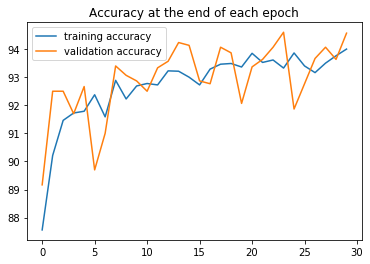

In [20]:
plt.plot(train_accuracy, label='training accuracy')
plt.plot(test_accuracy, label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();